In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import jax
import jax.numpy as jnp

In [2]:
df = pd.read_csv("optim_evaluation.csv", index_col=0)

df.insert(10, "AR", df["b"]/df["c"])

df.insert(14, "LD_ratio", df["L"]/ df["D"])

df.head()

,lift_goal,v_infty,altitude,alpha_geo,B,T,P,C,E,R,AR,b,c,L,LD_ratio,D,time
0,9999.994,95.598816,1065.2062,3.432269,1.766099,0.166530,2.960293,1.182179e-02,0.995304,0.017997,7.055989,7.055989,1.0,10032.12804,33.833399,296.515528,13.089736
1,9999.994,108.808140,3246.1655,0.734761,1.699920,0.162388,2.834756,2.430560e-02,0.965241,0.014733,7.753572,7.753572,1.0,10033.78567,47.870427,209.603014,67.353632
2,9999.994,157.776700,7765.6600,0.752891,1.754575,0.175176,2.932717,2.660000e-17,0.989982,0.000220,7.161887,7.161887,1.0,10031.71461,35.769628,280.453419,28.736861
3,9999.994,235.891110,4487.9290,1.628609,1.717111,0.198824,2.865658,1.986873e-02,0.982212,0.018517,5.000000,5.000000,1.0,13027.43611,30.751771,423.632064,27.914546
4,9999.994,119.611970,2060.0298,5.206943,1.707645,0.157157,2.843198,7.330540e-03,0.964584,0.019820,5.000000,5.000000,1.0,13696.30558,26.303177,520.709182,11.009721


In [3]:
df.insert(14, "lift_error", (df["L"] - df["lift_goal"]).abs() / df["lift_goal"])
cleaned_df = df.query("lift_error <= 0.01").copy()

cleaned_df.head()

,lift_goal,v_infty,altitude,alpha_geo,B,T,P,C,E,R,AR,b,c,L,lift_error,LD_ratio,D,time
0,9999.994,95.598816,1065.2062,3.432269,1.766099,0.166530,2.960293,1.182179e-02,0.995304,0.017997,7.055989,7.055989,1.000000,10032.128040,0.003213,33.833399,296.515528,13.089736
1,9999.994,108.808140,3246.1655,0.734761,1.699920,0.162388,2.834756,2.430560e-02,0.965241,0.014733,7.753572,7.753572,1.000000,10033.785670,0.003379,47.870427,209.603014,67.353632
2,9999.994,157.776700,7765.6600,0.752891,1.754575,0.175176,2.932717,2.660000e-17,0.989982,0.000220,7.161887,7.161887,1.000000,10031.714610,0.003172,35.769628,280.453419,28.736861
8,9999.994,50.435795,9991.7950,0.138556,1.673423,0.150000,2.788321,2.372530e-02,0.947188,0.005107,14.931614,24.551570,1.644268,9931.072314,0.006892,56.051699,177.177007,21.886007
11,9999.994,142.049530,8529.5130,2.093887,1.752473,0.189927,2.926725,1.161523e-02,0.998886,0.013842,7.817631,7.817631,1.000000,10031.147060,0.003115,37.512889,267.405345,10.648830


In [4]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = jnp.average(values, weights=weights)
    # Fast and numerically precise:
    variance = jnp.average((values-average)**2, weights=weights)
    return (average, jnp.sqrt(variance))

In [5]:
lift_goal = df["lift_goal"]

#Lift of unique lift goals
lift_goals = jnp.array(lift_goal)[::20]

In [6]:
def batch_by_lift(df, column):
    total = []
    for goal in lift_goals:
        filtered = df[df["lift_goal"] == goal]
        total.append(jnp.array(filtered[column]).mean())
        
    return jnp.array(total)

In [7]:
from matplotlib.ticker import FuncFormatter


def sci_format(x,lim):
    return '{:.0e}'.format(x)

major_formatter = FuncFormatter(sci_format)

In [8]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Weighted Average Lift Error: 0.026964823
Standard Deviation: 0.119894646


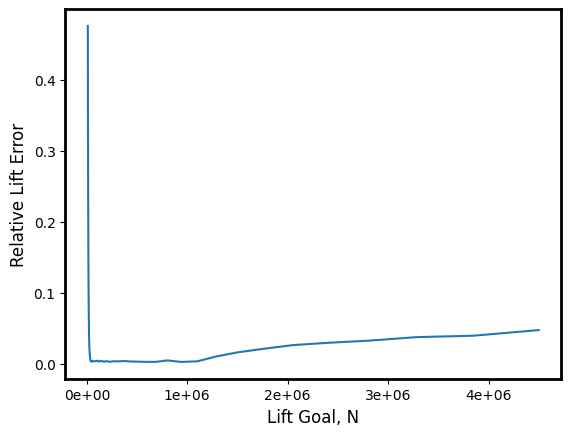

In [9]:
#Batch the lift errors
lift_errors = batch_by_lift(df, "lift_error")

all_lift_goals = jnp.array(df["lift_goal"])
all_lift_error = jnp.array(df["lift_error"])

average, stddev = weighted_avg_and_std(all_lift_error, all_lift_goals)

print("Weighted Average Lift Error:", average)
print("Standard Deviation:", stddev)

if True:
    fig, ax = plt.subplots()
    
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, lift_errors, 1)

    #Plot errors against the lift goals
    ax.plot(lift_goals, lift_errors)

    #Plot line of best fit
    #ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="Relative Lift Error")
    #ax.legend()

    fig.savefig(
        "./graphs/uncleaned_lift_error.pdf",
        bbox_inches='tight',
    )

    fig.show();

Weighted Average Lift Error: 0.002780078
Standard Deviation: 0.002108501
Slope: -3.8176864e-10


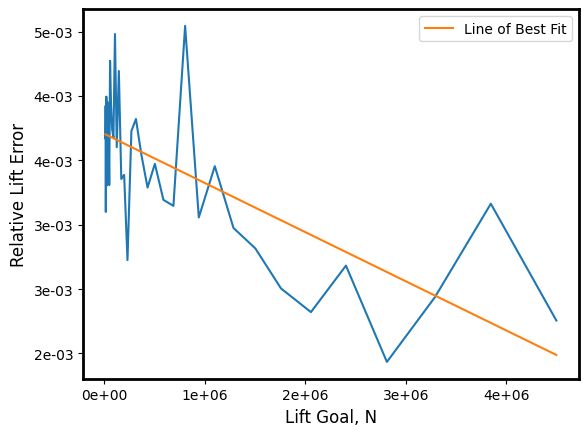

In [10]:
#Batch the lift errors
lift_errors = batch_by_lift(cleaned_df, "lift_error")

all_lift_goals = jnp.array(cleaned_df["lift_goal"])
all_lift_error = jnp.array(cleaned_df["lift_error"])

average, stddev = weighted_avg_and_std(all_lift_error, all_lift_goals)

print("Weighted Average Lift Error:", average)
print("Standard Deviation:", stddev)

if True:
    
    fig, ax = plt.subplots()
    
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)
    ax.get_yaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, lift_errors, 1)
    print("Slope:", best_fit[0])

    #Plot errors against the lift goals
    ax.plot(lift_goals, lift_errors)

    #Plot line of best fit
    ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="Relative Lift Error")
    ax.legend()

    fig.savefig(
        "./graphs/cleaned_lift_error.pdf",
        bbox_inches='tight',
    )

    fig.show()

Weighted Average L/D Ratio: 27.629728
Standard Deviation: 15.817517
Slope: -6.5228405e-06


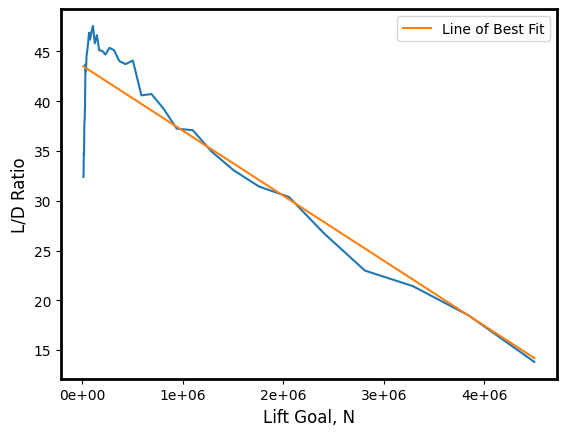

In [11]:
LD_ratio = batch_by_lift(df, "LD_ratio")


all_lift_goals = jnp.array(df["lift_goal"])
all_ld_ratio = jnp.array(df["LD_ratio"])

average, stddev = weighted_avg_and_std(all_ld_ratio, all_lift_goals)

print("Weighted Average L/D Ratio:", average)
print("Standard Deviation:", stddev)

if True:
    
    fig, ax = plt.subplots()
    
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, LD_ratio, 1)
    print("Slope:", best_fit[0])

    #Plot errors against the lift goals
    ax.plot(lift_goals, LD_ratio)

    #Plot line of best fit
    ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="L/D Ratio")
    ax.legend()

    fig.savefig(
        "./graphs/uncleaned_ld_ratio.pdf",
        bbox_inches='tight',
    )

    fig.show();

Weighted Average L/D Ratio: 29.22054
Standard Deviation: 14.792104
Slope: -6.4428377e-06


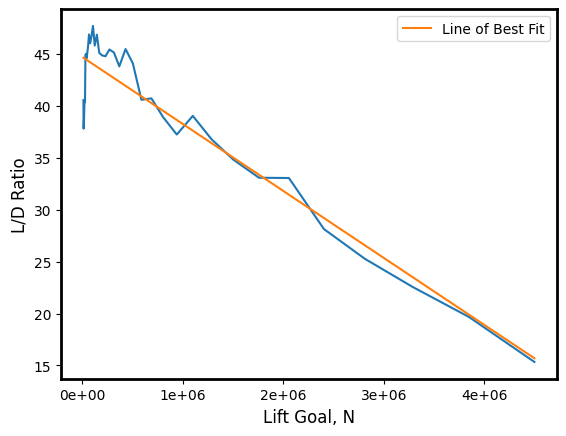

In [12]:
LD_ratio = batch_by_lift(cleaned_df, "LD_ratio")

all_lift_goals = jnp.array(cleaned_df["lift_goal"])
all_ld_ratio = jnp.array(cleaned_df["LD_ratio"])

average, stddev = weighted_avg_and_std(all_ld_ratio, all_lift_goals)

print("Weighted Average L/D Ratio:", average)
print("Standard Deviation:", stddev)

if True:
    
    fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, LD_ratio, 1)
    print("Slope:", best_fit[0])

    #Plot errors against the lift goals
    ax.plot(lift_goals, LD_ratio)

    #Plot line of best fit
    ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="L/D Ratio")
    ax.legend()

    fig.savefig(
        "./graphs/cleaned_ld_ratio.pdf",
        bbox_inches='tight',
    )

    fig.show();

Weighted Average Time: 37.550026
Standard Deviation: 87.93945
Slope: 4.4126996e-06


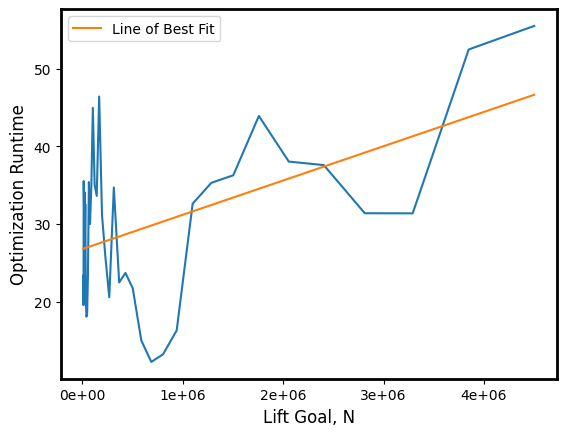

In [13]:
times = batch_by_lift(df, "time")

all_lift_goals = jnp.array(df["lift_goal"])
all_time = jnp.array(df["time"])

average, stddev = weighted_avg_and_std(all_time, all_lift_goals)

print("Weighted Average Time:", average)
print("Standard Deviation:", stddev)

if True:
    
    fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, times, 1)
    print("Slope:", best_fit[0])

    #Plot errors against the lift goals
    ax.plot(lift_goals, times)

    #Plot line of best fit
    ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="Optimization Runtime")
    ax.legend()

    fig.savefig(
        "./graphs/uncleaned_time.pdf",
        bbox_inches='tight',
    )

    fig.show();

Weighted Average Time: 17.288176
Standard Deviation: 18.210135
Slope: -3.0074202e-06


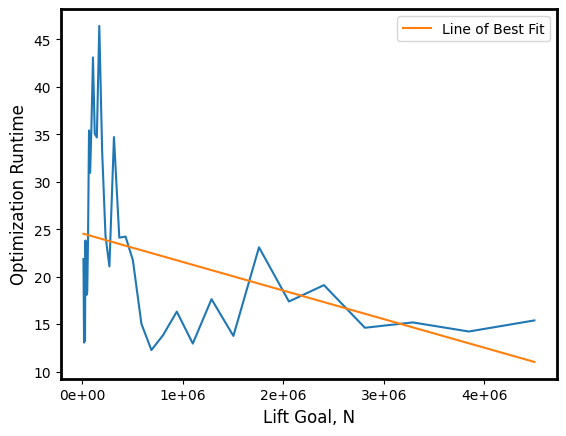

In [14]:
times = batch_by_lift(cleaned_df, "time")

all_lift_goals = jnp.array(cleaned_df["lift_goal"])
all_time = jnp.array(cleaned_df["time"])

average, stddev = weighted_avg_and_std(all_time, all_lift_goals)

print("Weighted Average Time:", average)
print("Standard Deviation:", stddev)

if True:
    
    fig, ax = plt.subplots()
    plt.setp(ax.spines.values(), linewidth=2)

    ax.get_xaxis().set_major_formatter(major_formatter)

    #Line of best fit
    best_fit = jnp.polyfit(lift_goals, times, 1)
    print("Slope:", best_fit[0])

    #Plot errors against the lift goals
    ax.plot(lift_goals, times)

    #Plot line of best fit
    ax.plot(lift_goals, best_fit[0] * (lift_goals - lift_goals[0]) + best_fit[1], label="Line of Best Fit")
    ax.set(xlabel="Lift Goal, N", ylabel="Optimization Runtime")
    ax.legend()

    fig.savefig(
        "./graphs/cleaned_time.pdf",
        bbox_inches='tight',
    )

    fig.show();

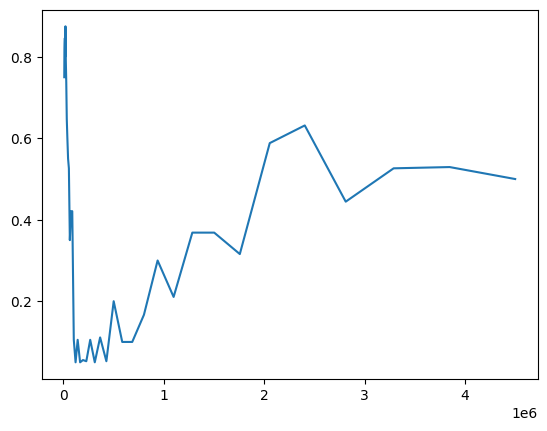

In [15]:
#Bounds checking
dv_bounds = {
    "B": (1.5, 1.8),
    "T": (0.15, 0.25),
    "P": (2.5, 3.5),
    "C": (0, 0.75),
    "E": (0.6, 1),
    "R": (-0.02, 0.02),
    "c": (1, 4),
    "AR": (5, 15)
}

df = cleaned_df.copy()

dv_name = "c"

#Mask dataframe to see if DV matches bounds
masked_df = (df[dv_name] == dv_bounds[dv_name][0]) | (df[dv_name] == dv_bounds[dv_name][1])

#Convert bools to ints
masked_arr = jnp.array(masked_df, dtype=jnp.int32)

df.insert(0, "boundary_hit", masked_arr)

#Find amount of times boundary hit for each lift goal
boundary_hits = batch_by_lift(df, "boundary_hit")

plt.plot(lift_goals, boundary_hits);

Slope: -0.0013477249


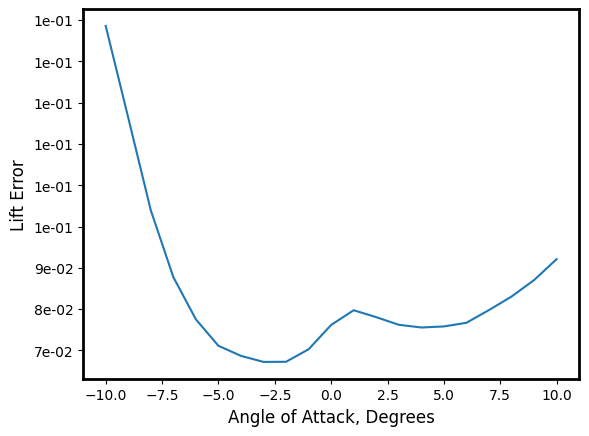

In [16]:
alphas = jnp.array([-10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, -0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
lift_errors = jnp.array([0.14857908, 0.1263491, 0.10394182, 0.08775361, 0.077522315, 0.0711188, 0.06867903, 0.067211986, 0.06724958, 0.07027316, 0.07616887, 0.079729624, 0.07804949, 0.076205835, 0.075549155, 0.07580478, 0.07669093, 0.079772055, 0.08304291, 0.087030284, 0.09210141])

fig, ax = plt.subplots()
plt.setp(ax.spines.values(), linewidth=2)

ax.get_yaxis().set_major_formatter(major_formatter)

#Line of best fit
best_fit = jnp.polyfit(alphas, lift_errors, 1)
print("Slope:", best_fit[0])

#Plot errors against the lift goals
ax.plot(alphas, lift_errors)

#Plot line of best fit
#ax.plot(alphas, best_fit[0] * (alphas - alphas[0]) + best_fit[1], label="Line of Best Fit")
ax.set(xlabel="Angle of Attack, Degrees", ylabel="Lift Error")
#ax.legend()

fig.savefig(
    "./graphs/lift_error.pdf",
    bbox_inches='tight',
)

fig.show();

Slope: -0.00046030284


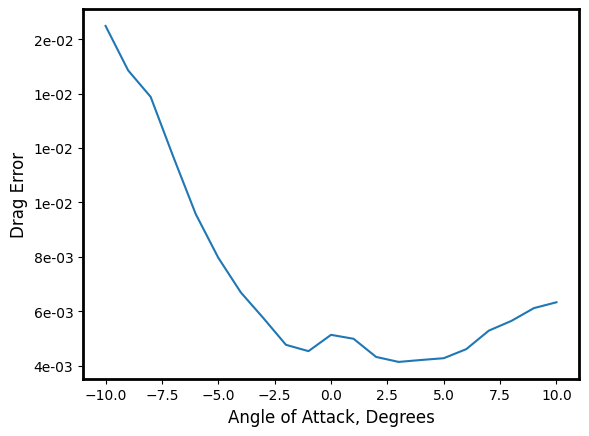

In [17]:
drag_errors = jnp.array([0.016487412, 0.014853964, 0.013878155, 0.011684904, 0.009568411, 0.00796277, 0.0066874204, 0.0057438435, 0.0047624484, 0.0045293234, 0.0051289457, 0.0049842, 0.004316453, 0.00413323, 0.004205009, 0.0042698975, 0.004603968, 0.0052841213, 0.0056413393, 0.006112467, 0.006326402])

fig, ax = plt.subplots()
plt.setp(ax.spines.values(), linewidth=2)

ax.get_yaxis().set_major_formatter(major_formatter)

#Line of best fit
best_fit = jnp.polyfit(alphas, drag_errors, 1)
print("Slope:", best_fit[0])

#Plot errors against the lift goals
ax.plot(alphas, drag_errors)

#Plot line of best fit
#ax.plot(alphas, best_fit[0] * (alphas - alphas[0]) + best_fit[1], label="Line of Best Fit")
ax.set(xlabel="Angle of Attack, Degrees", ylabel="Drag Error")
#ax.legend()

fig.savefig(
    "./graphs/drag_error.pdf",
    bbox_inches='tight',
)

fig.show();